# Conditional Restricted Boltzmann Machines in R

### CRBM training and testing algorithms, coded in plain R.

Here you can find a Conditional Restricted Boltzmann Machines, implemented in R and in plain algorithm, for academic and educational purposes.

@authors Josep Ll. Berral, David Buchaca (Barcelona Supercomputing Center)

@date 1st December, 2016

### References
* Approach based on <a href="http://www.uoguelph.ca/~gwtaylor/">Graham Taylor</a>'s CRBM: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/gwtaylor_nips.pdf

### Mocap data
* R converted version: TODO - Here goes link to motion.rds
* Original file: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/motion.mat
* Data originally from Eugene Hsu, MIT. http://people.csail.mit.edu/ehsu/work/sig05stf/

## GENERIC FUNCTIONS

* **sample_normal**: Generates a matrix of random normal values
* **sample_bernoulli**: Generates a matrix of Bernoulli samples given a matrix of probabilities
* **sigmoid_func**: Performs the sigmoid calculus over a matrix
* **%+%**: Operator to sum a vector to a matrix by their coincident side (row checked before columm)

In [1]:
## Function to produce Normal Samples
sample_normal <- function(dims, mean = 0, sd = 1)
{
    array(rnorm(n = prod(dims), mean = mean, sd = sd), dims);
}

## Function to produce Bernoulli Samples
sample_bernoulli <- function(mat)
{
    dims <- dim(mat);
    array(rbinom(n = prod(dims), size = 1, prob = c(mat)), dims);
}

## Function to produce the Sigmoid
sigmoid_func <- function(mat)
{
    1 / (1 + exp(-mat));
}

## Operator to add dimension-wise vectors to matrices
`%+%` <- function(mat, vec)
{
    retval <- NULL;
    tryCatch(
        expr = { retval <- if (dim(mat)[1] == length(vec)) t(t(mat) + vec) else mat + vec; },
        warning = function(w) { print(paste("WARNING: ", w, sep = "")); },
        error = function(e) { print(paste("ERROR: Cannot sum mat and vec", e, sep = "\n")); }
    );
    retval;
}

## CRBM Functions

Functions for creating and operating CRBMs:

* **create_crbm**: The constructor function
* **free_energy_crbm**: The target cost function
* **sample_h_given_v_crbm**: Activation function given input
* **sample_v_given_h_crbm**: Reconstruction function given activations
* **get_cost_updates_crbm**: One step of Contrastive Divergence (CD-k) process updating the CRBM

In [2]:
## Conditional Restricted Boltzmann Machine (CRBM). Constructor
create_crbm <- function (n_visible = 49, n_hidden = 100, delay = 6, A = NULL, B = NULL, W = NULL, hbias = NULL, vbias = NULL, rand_seed = 1234)
{
    set.seed(rand_seed);

    if (is.null(W)) W <- 0.01 * sample_normal(c(n_visible, n_hidden)); #/ (n_visible + n_hidden);
    if (is.null(A)) A <- 0.01 * sample_normal(c(n_visible * delay, n_visible)); #/ (n_visible + n_hidden);
    if (is.null(B)) B <- 0.01 * sample_normal(c(n_visible * delay, n_hidden)); #/ (n_visible + n_hidden);

    if (is.null(hbias)) hbias <- rep(0, n_hidden);
    if (is.null(vbias)) vbias <- rep(0, n_visible);
    
    velocity <- list(W = array(0, dim(W)), A = array(0, dim(A)), B = array(0, dim(B)),
                     v = rep(0, length(vbias)), h = rep(0, length(hbias)));

    list(n_visible = n_visible, n_hidden = n_hidden, delay = delay,
         W = W, A = A, B = B, hbias = hbias, vbias = vbias, velocity = velocity);
}

## Function to compute the free energy of a sample conditional on the history
free_energy_crbm <- function(crbm, visible_state, v_history)
{
    wx_b <- (visible_state %*% crbm$W + v_history %*% crbm$B) %+% crbm$hbias;
    ax_b <- (v_history %*% crbm$A) %+% crbm$vbias;
    visible_term <- rowSums(0.5 * `^`(visible_state - ax_b,2));
    hidden_term <- rowSums(log(1 + exp(wx_b)));

    (visible_term - hidden_term);
}

### This function infers state of hidden units given visible units
sample_h_given_v_crbm <- function(crbm, visible_state, v_history)
{
    h.mean <- sigmoid_func((visible_state %*% crbm$W + v_history %*% crbm$B) %+% crbm$hbias);
    h.sample <- sample_bernoulli(h.mean);

    list(mean = h.mean, sample = h.sample);
}

## This function infers state of visible units given hidden units
sample_v_given_h_crbm <- function(crbm, hidden_state, v_history)
{
    ##v.mean <- sigmoid_func((hidden_state %*% t(crbm$W) + v_history %*% crbm$A) %+% crbm$vbias);
    ##v.sample <- sample_bernoulli(v.mean);

    v.mean <- (hidden_state %*% t(crbm$W) + v_history %*% crbm$A) %+% crbm$vbias;
    v.sample <- v.mean;

    list(mean = v.mean, sample = v.sample);
}

## This functions implements one step of CD-k
##  param input: matrix input from batch data (n_seq x n_vis)
##  param input_hist: matrix input_history from batch data (n_seq x (n_vis * delay))
##  param lr: learning rate used to train the RBM
##  param k: number of Gibbs steps to do in CD-k
##  param momentum: value for momentum coefficient on learning
##  We assume sigma = 1 when computing deltas
get_cost_updates_crbm <- function(crbm, input, input_history, lr, k = 1, momentum = 0.1)
{
    # compute positive phase (awake)
    ph <- sample_h_given_v_crbm(crbm, input, input_history);

    # perform negative phase (asleep)
    nh <- ph;
    for (i in 1:k)
    {
        nv <- sample_v_given_h_crbm(crbm, nh[["sample"]], input_history);
        nh <- sample_h_given_v_crbm(crbm, nv[["sample"]], input_history);
    }

#    cost <- mean(free_energy_crbm(crbm, input, input_history)) -
#            mean(free_energy_crbm(crbm, nv[["sample"]], input_history));

    # determine gradients on CRBM parameters
    Delta_W <- t(input) %*% ph[["mean"]] - t(nv[["sample"]]) %*% nh[["mean"]];
    Delta_v <- colMeans(input - nv[["sample"]]);
    Delta_h <- colMeans(ph[["mean"]] - nh[["mean"]]);
    Delta_A <- t(input_history) %*% input - t(input_history) %*% nv[["sample"]];
    Delta_B <- t(input_history) %*% ph[["mean"]] - t(input_history) %*% nh[["mean"]];

    crbm$velocity[["W"]] <- crbm$velocity[["W"]] * momentum + lr * Delta_W;
    crbm$velocity[["A"]] <- crbm$velocity[["A"]] * momentum + lr * Delta_A;
    crbm$velocity[["B"]] <- crbm$velocity[["B"]] * momentum + lr * Delta_B;
    crbm$velocity[["v"]] <- crbm$velocity[["v"]] * momentum + lr * Delta_v;
    crbm$velocity[["h"]] <- crbm$velocity[["h"]] * momentum + lr * Delta_h;

    # update weights
    crbm$W <- crbm$W + crbm$velocity[["W"]];
    crbm$A <- crbm$A + crbm$velocity[["A"]];
    crbm$B <- crbm$B + crbm$velocity[["B"]];
    crbm$vbias <- crbm$vbias + crbm$velocity[["v"]];
    crbm$hbias <- crbm$hbias + crbm$velocity[["h"]];

    # approximation to the reconstruction error: sum over dimensions, mean over cases
    list(crbm = crbm, recon = mean(rowSums(`^`(input - nv[["mean"]],2))));
}

## How to train your CRBM

Functions to train a CRBM from a loaded DataSet:

* **train_crbm**: Creates and trains a CRBM from a given dataset

In [3]:
## Function to train the CRBM
##  param learning_rate: learning rate used for training the CRBM
##  param training_epochs: number of epochs used for training
##  param dataset: loaded dataset <batchdata, seqlen, data_mean, data_std> for Motion
##  param batch_size: size of a batch used to train the CRBM
train_crbm <- function (dataset, learning_rate = 1e-4, momentum = 0.5, training_epochs = 300, batch_size = 100, n_hidden = 100, delay = 6)
{
    set.seed(123);

    # prepare indexes for dataset
    batchdata <- dataset$batchdata;
    seqlen <- dataset$seqlen;

    # compute number of minibatches for training, validation and testing
    n_train_batches <- ceiling(nrow(batchdata) / batch_size);
    n_dim <- ncol(batchdata);

    # valid starting indices
    batchdataindex <- NULL;
    last <- 1;
    for (s in seqlen)
    {
        batchdataindex <- c(batchdataindex, (last + delay):(last + s - 1));
        last <- last + s;
    }
    permindex <- batchdataindex[sample(1:length(batchdataindex),length(batchdataindex))];

    # construct the CRBM object
    crbm <- create_crbm(n_visible = n_dim, n_hidden = n_hidden, delay = delay, rand_seed = 123);

    start_time <- Sys.time();

    # go through the training epochs
    for (epoch in 1:training_epochs)
    {
        # go through the training set
        mean_cost <- NULL;

        for (batch_index in 1:n_train_batches)
        {
            # linear index to the starting frames for this batch
            idx.aux.ini <- (((batch_index - 1) * batch_size) + 1);
            idx.aux.fin <- (batch_index * batch_size);
            if (idx.aux.fin > length(permindex)) break;
            data_idx <- permindex[idx.aux.ini:idx.aux.fin];

            # linear index to the frames at each delay tap
            hist_idx <- c(t(sapply(1:delay, function(x) data_idx - x)));

            # update the CRBM parameters
            input <- batchdata[data_idx,];
            input_history <- t(array(c(t(batchdata[hist_idx,])), c(delay * n_dim, batch_size)));

            # get the cost and the gradient corresponding to one step of CD-k
            aux <- get_cost_updates_crbm(crbm, input, input_history, lr = learning_rate, momentum = momentum, k = 1);
            this_cost <- aux$recon;
            crbm <- aux$crbm;

            mean_cost <- c(mean_cost, this_cost);
        }
        if (epoch %% 50 == 1) print(paste('Training epoch ',epoch,', cost is ',mean(mean_cost, na.rm = TRUE),sep=""));
    }

    end_time <- Sys.time();
    print(paste('Training took', (end_time - start_time),'minutes',sep=" "));

    crbm;
}

## Predicting Values

Functions to predict a sequence from a CRBM:

* **predict_crbm** (a.k.a. generate_crbm): Generates _n_ samples from an input and some history using a CRBM

In [4]:
## Given initialization(s) of visibles and matching history, generate n_samples in future.
##  orig_data : n_seq by n_visibles array, initialization for first frame
##  orig_history : n_seq by delay * n_visibles array, delay-step history
##  n_samples : int, number of samples to generate forward
##  n_gibbs : int, number of alternating Gibbs steps per iteration
predict_crbm <- function(crbm, orig_data, orig_history, n_samples, n_gibbs = 30)
{
    n_seq <- nrow(orig_data);

    persistent_vis_chain <<- orig_data;
    persistent_history <<- orig_history;

        # construct the function that implements our persistent chain.
    sample_fn <- function(crbm, n_gibbs)
    {
        vis_sample <- persistent_vis_chain;
        v_history <- persistent_history;

        vis_mf <- NULL;
        for (k in 1:n_gibbs)
        {
            hid <- sample_h_given_v_crbm(crbm, vis_sample, v_history);
            vis <- sample_v_given_h_crbm(crbm, hid[["sample"]], v_history);

            vis_mf <- vis[["mean"]];
            vis_sample <- vis[["sample"]];
        }

        # add to updates the shared variable that takes care of our persistent chain
        persistent_vis_chain <<- vis_sample;
        persistent_history <<- cbind(vis_sample, persistent_history[,1:((crbm$delay - 1) * crbm$n_visible)]);

        vis_mf;
    }

    generated_series <- array(0,c(n_seq, n_samples, crbm$n_visible));
    for (t in 1:n_samples)
    {
        #if (t %% 10 == 1) print(paste("Generating frame ", t, " to ", min(t+9, n_samples), sep = ""));
        generated_series[,t,] <- sample_fn(crbm, n_gibbs);
    }
    generated_series;
}

## Load Data

Functions to load data from a file name (for Motion example):

* **load_data**: Loads a motion.rds containing the Motion example data. The Motion example must be converted from Matlab format to RDS

In [5]:
## Function to Load and Preprocess the Motion Example Data.
##  :param filename: The URI of the motion.rds file with the matrix structure from Motion
##  :return list: <batchdata, seqlen, data_mean, data_std>
##  Source: TODO - motion.rds (version of motion.mat converted into R Data Storage format)
load_data <- function(filename)
{
    mat_dict <- readRDS(filename);
    Motion <- mat_dict[['Motion']];

    n_seq <- length(Motion);

    # assume data is MIT format for now
    indx <- c(1:9, 14, 19:21, 26, 31:33, 38, 43:45, 50, 55:57, 61:63, 67:69, 73:75,
                79:81, 85:87, 91:93, 97:99, 103:105);

    ##row1 <- Motion[[c(1,1)]][1,];
    ##offsets <- array(row1[c(10:12, 16:18, 22:24, 28:30, 34:36, 40:42, 46:48, 52:54,
    ##            58:60, 64:66, 70:72, 76:78, 82:84, 88:90, 94:96, 100:102,
    ##            106:108)], c(3, length(row1)/3) );

    # collapse sequences
    batchdata <- rbind(Motion[[c(1,1)]][,indx],
                       Motion[[c(2,1)]][,indx],
                       Motion[[c(3,1)]][,indx]);
    data_mean <- colMeans(batchdata);
    data_std <- apply(batchdata, 2, sd);

    batchdata <- t((t(batchdata) - data_mean) / data_std);

    # get sequence lengths
    seqlen <- sapply(1:3, function(x) nrow(Motion[[c(x,1)]]));

    list(batchdata = batchdata, seqlen = seqlen, data_mean = data_mean, data_std = data_std);
}


## Main Program

Example using the Motion dataset.

In [6]:
# Load data and create the CRBM
dataset <- load_data('../datasets/motion.rds');                     # List <batchdata, seqlen, data_mean, data_std>
crbm <- train_crbm(dataset);                                        # Trained CRBM

[1] "Training epoch 1, cost is 14.0930354056327"
[1] "Training epoch 51, cost is 5.31627640481918"
[1] "Training epoch 101, cost is 5.68397009514745"
[1] "Training epoch 151, cost is 5.76636046683365"
[1] "Training epoch 201, cost is 5.66341695803149"
[1] "Training epoch 251, cost is 5.62400992327472"
[1] "Training took 0.0522481455405553 minutes"


In [7]:
# Generate some sequences (in parallel) from CRBM
# Using training data as initialization

batchdata <- dataset$batchdata;                                     # DIMS - Motion.mat (3826, 49)

# pick some starting points for each sequence
data_idx <- c(100, 200, 400, 600);
orig_data <- batchdata[data_idx,];                                  # DIMS - Motion.mat (3826, data_idx.length)

hist_idx <- c(sapply(data_idx, function(x) x - 1:crbm$delay));
orig_history <- t(array(as.vector(t(batchdata[hist_idx,])), c(crbm$delay * crbm$n_visible, length(data_idx))));

In [9]:
generated_series.aux <- predict_crbm(crbm, orig_data, orig_history, n_samples = 100, n_gibbs = 30);

# append initialization
library(abind)
oh.temp <- aperm(array(as.vector(orig_history), c(length(data_idx), crbm$n_visible, crbm$delay)),c(1,3,2));
generated_series <- abind(oh.temp[,crbm$delay:1,], generated_series.aux, along = 2);

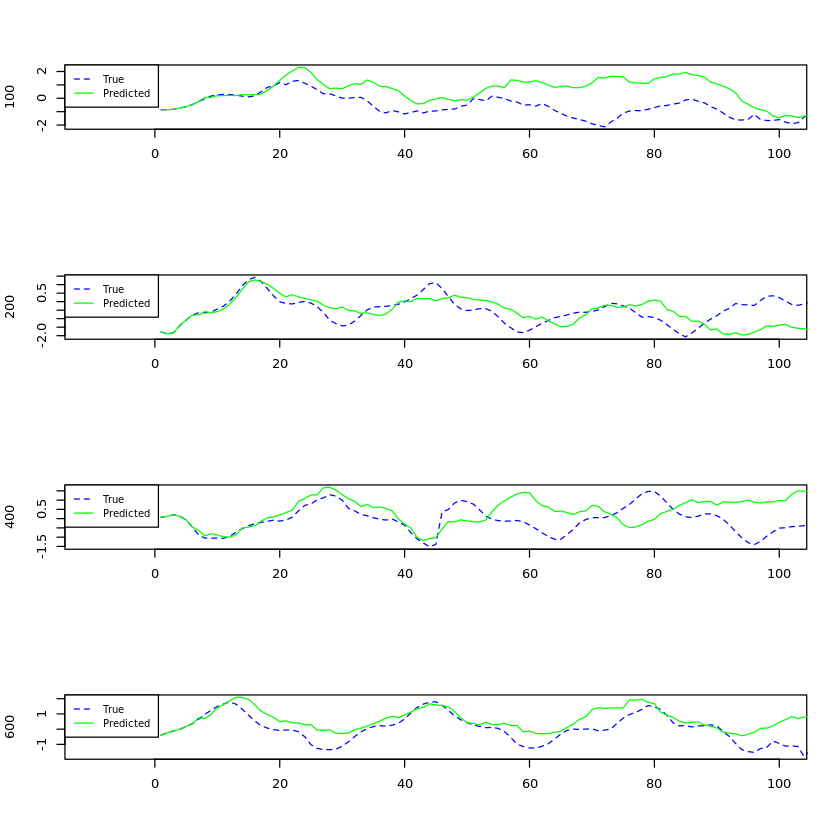

In [10]:
#plot first dimension of each sequence
par(mfrow = c(length(data_idx) ,1));
for (i in 1:length(data_idx))
{
    start <- data_idx[i];
    
    plot.true <- batchdata[(start - crbm$delay):(start + 100), 2];
    plot.pred <- generated_series[i,, 2];

    plot(plot.true, col = "blue", type = "l", lty = 2, xlab = "", ylab = data_idx[i], xlim = c(-10,100), ylim = c(min(plot.true, plot.pred),max(plot.true, plot.pred)));
    lines(plot.pred, col = "green");
    legend("topleft", legend = c("True", "Predicted"), col = c("blue","green"), lty = c(2,1), cex = 0.75, y.intersp = 1);
}